Based on: https://colab.research.google.com/github/Adapter-Hub/adapter-transformers/blob/master/notebooks/03_Adapter_Fusion.ipynb#scrollTo=INW7UEhC-I6b

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from transformers import BertTokenizer, BertConfig, BertModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction
from transformers.adapters.composition import Fuse

In [2]:
dataset = load_dataset("super_glue", "cb")
dataset.num_rows

Reusing dataset super_glue (/nfs/datz/hangyav/.huggingface/datasets/super_glue/cb/1.0.2/d040c658e2ddef6934fdd97deb45c777b6ff50c524781ea434e7219b56a428a7)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 250, 'validation': 56, 'test': 250}

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(
      batch["premise"],
      batch["hypothesis"],
      max_length=180,
      truncation=True,
      padding="max_length"
  )

# Encode the input data
dataset = dataset.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset.rename_column_("label", "labels")
# Transform to pytorch tensors and only output the required columns
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Loading cached processed dataset at /nfs/datz/hangyav/.huggingface/datasets/super_glue/cb/1.0.2/d040c658e2ddef6934fdd97deb45c777b6ff50c524781ea434e7219b56a428a7/cache-e6748383b0d7249e.arrow
Loading cached processed dataset at /nfs/datz/hangyav/.huggingface/datasets/super_glue/cb/1.0.2/d040c658e2ddef6934fdd97deb45c777b6ff50c524781ea434e7219b56a428a7/cache-68e640accb1bbd4c.arrow
Loading cached processed dataset at /nfs/datz/hangyav/.huggingface/datasets/super_glue/cb/1.0.2/d040c658e2ddef6934fdd97deb45c777b6ff50c524781ea434e7219b56a428a7/cache-43c019c30b40a14d.arrow
/tmp/ipykernel_3035702/4175906235.py:16: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.rename_column instead.
  dataset.rename_column_("label", "labels")


In [4]:
id2label = {id: label for (id, label) in enumerate(dataset["train"].features["labels"].names)}

config = BertConfig.from_pretrained(
    "bert-base-uncased",
    id2label=id2label,
)
model = BertModelWithHeads.from_pretrained(
    "bert-base-uncased",
    config=config,
)

/mounts/Users/student/hangyav/ext_proj/.anaconda_new/envs/adapters/lib/python3.9/site-packages/transformers/adapters/models/bert.py:245: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
/mounts/Users/student/hangyav/ext_proj/.anaconda_new/envs/adapters/lib/python3.9/site-packages/transformers/adapters/models/bert.py:223: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModelWithHeads: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq

In [5]:
# Load the pre-trained adapters we want to fuse
model.load_adapter("nli/multinli@ukp", load_as="multinli", with_head=False)
model.load_adapter("sts/qqp@ukp", with_head=False)
model.load_adapter("nli/qnli@ukp", with_head=False)
# Add a fusion layer for all loaded adapters
model.add_adapter_fusion(Fuse("multinli", "qqp", "qnli"))
model.set_active_adapters(Fuse("multinli", "qqp", "qnli"))

# Add a classification head for our target task
model.add_classification_head("cb", num_labels=len(id2label))

In [6]:
adapter_setup = Fuse("multinli", "qqp", "qnli")
model.train_adapter_fusion(adapter_setup)

In [7]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="../tmp/notebook_outputs/fusion_visualization",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
)

In [8]:
trainer.train()

/mounts/Users/student/hangyav/ext_proj/.anaconda_new/envs/adapters/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 250
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8, training_loss=0.9666537046432495, metrics={'train_runtime': 4.5864, 'train_samples_per_second': 54.509, 'train_steps_per_second': 1.744, 'total_flos': 29747296170000.0, 'train_loss': 0.9666537046432495, 'epoch': 1.0})

In [14]:
trainer.evaluate()  # implicit model.eval() which is needed for fuse attention scores to be saved

***** Running Evaluation *****
  Num examples = 56
  Batch size = 32


{'eval_loss': 0.9308117032051086,
 'eval_acc': 0.5,
 'eval_runtime': 0.4511,
 'eval_samples_per_second': 124.141,
 'eval_steps_per_second': 4.434,
 'epoch': 1.0}

In [10]:
def predict(premise, hypothesis):
    encoded = tokenizer(premise, hypothesis, return_tensors="pt")
    if torch.cuda.is_available():
        encoded.to("cuda")
    logits = model(**encoded)[0]
    pred_class = torch.argmax(logits).item()
    return id2label[pred_class]

In [11]:
predict("""
``It doesn't happen very often.'' Karen went home
happy at the end of the day. She didn't think that
the work was difficult.
""",
"the work was difficult"
)

'contradiction'

In [15]:
model.bert.encoder.layer[1].output.adapter_fusion_layer[adapter_setup.name].recent_attention.shape

(24, 180, 3)

In [34]:
def get_averaged_fusion_attentions(model_encoder, fusion_name):
    return np.array([
        layer.output.adapter_fusion_layer[fusion_name].recent_attention.mean(axis=(0, 1))
        for layer in model_encoder.layer
    ])

In [39]:
def get_eval_fusion_attentions(model, fusion_name, trainer):
    res = list()
    for batch in trainer.get_eval_dataloader():
        batch = trainer._prepare_inputs(batch)
        model(**batch)
        res.append(get_averaged_fusion_attentions(model.bert.encoder, fusion_name))
        
    return np.array(res).mean(axis=0)

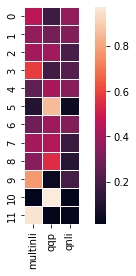

In [40]:
matrix = get_eval_fusion_attentions(model, adapter_setup.name, trainer)
ax = sns.heatmap(
    matrix,
    linewidth=0.5,
    square=True,
    xticklabels=adapter_setup.name.split(','),
)
plt.show()

In [ ]:
ax = sns.heatmap(
    matrix,
    linewidth=0.5,
    square=True,
    xticklabels=adapter_setup.name.split(','),
)
plt.show()